In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.nn import depth_to_space
from tensorflow.keras.applications import VGG19
from keras.models import load_model
from keras.layers import BatchNormalization, GlobalAvgPool2D, LeakyReLU, Lambda
from keras.layers import Conv2D, Dense, Add, Rescaling
from tensorflow.nn import depth_to_space
from keras import Model
from keras import Input
from PIL import Image

In [2]:
low_shape = (96, 96, 3)
high_shape = (384, 384, 3)

In [3]:
def image_resizer(hr_path,lr_path):
    hr_image_store = {}
    lr_image_store = {}
    
    hr_image_dir = glob.glob(hr_path)
    lr_image_dir = glob.glob(lr_path)
    
    for i,j in zip(hr_image_dir,lr_image_dir):
        hr_filename = i.split('/')[-1].split('.')[0]
        lr_filename = j.split('/')[-1].split('.')[0]
        
        hr_image = Image.open(i)
        lr_image = Image.open(j)
        
        hr_image_store[hr_filename] = np.array(hr_image)
        lr_image_store[lr_filename] = np.array(lr_image)
        
    return hr_image_store,lr_image_store

In [4]:
hr_path = '../input/super-image-resolution/Data/HR/*'
lr_path = '../input/super-image-resolution/Data/LR/*'

a,b = image_resizer(hr_path,lr_path)

hr_image_store,lr_image_store = list(a.values()), list(b.values())

hr_image_store = np.stack(hr_image_store)
lr_image_store = np.stack(lr_image_store)

In [5]:
LR_train, LR_val, HR_train, HR_val = train_test_split(lr_image_store, hr_image_store, test_size=0.1)
print(LR_train.shape, HR_train.shape)
print(LR_val.shape, HR_val.shape)

(90, 96, 96, 3) (90, 384, 384, 3)
(10, 96, 96, 3) (10, 384, 384, 3)


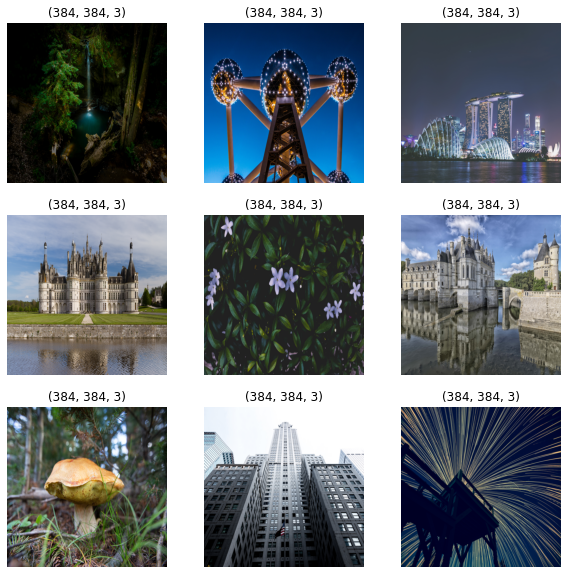

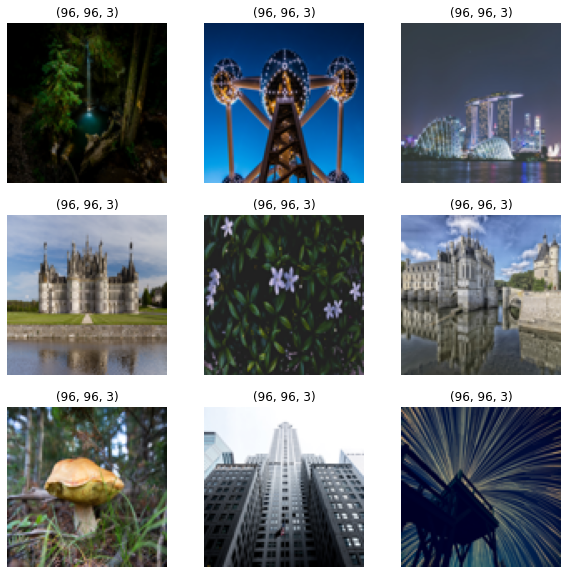

In [6]:
lowres, highres = LR_train[:9], HR_train[:9]

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i])
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i])
    plt.title(lowres[i].shape)
    plt.axis("off")

In [7]:
class Losses:
    def __init__(self):
        pass
    
    def bce_loss(self, real, pred):
        bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        loss = bce(real, pred)
        loss = tf.reduce_mean(loss)
        return loss
    
    def mse_loss(self, real, pred):
        mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        loss = mse(real, pred)
        loss = tf.reduce_mean(loss)
        return loss
    
    def discriminator_loss(self, real_output, fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def PSNR(self, super_resolution, high_resolution):
        """Compute the peak signal-to-noise ratio, measures quality of image."""
        # Max value of pixel is 255
        psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
        return psnr_value

In [8]:
 def build_VGG():
    vgg = VGG19(input_shape=(None, None, 3), weights="imagenet", include_top=False)
    model = tf.keras.Model(vgg.input, vgg.layers[20].output)
    return model

In [9]:
def residual_block(passed_input,kernel_size,feature_maps,leaky_alpha):
    x = tf.keras.layers.Conv2D(filters=feature_maps, kernel_size=kernel_size, padding="same")(passed_input)
    x = tf.keras.layers.BatchNormalization(momentum=0.5)(x)
    x1 = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)
    #x1 = tf.keras.layers.LeakyReLU(leaky_alpha)(x)
    x1 = tf.keras.layers.Conv2D(filters=feature_maps, kernel_size=kernel_size, padding="same")(x1)
    x1 = tf.keras.layers.BatchNormalization(momentum=0.5)(x1)
    x1 = tf.keras.layers.Add()([passed_input, x1])
    
    return x1     

In [10]:
def upscaler(passed_input,scaling_factor,feature_maps,kernel_size,leaky_alpha):
    x = tf.keras.layers.Conv2D(filters=feature_maps, kernel_size=kernel_size,padding="same")(passed_input)
    x = tf.nn.depth_to_space(x, 2)
    #x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)
    x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)
    
    return x

In [11]:
def generator(scaling_factor, feature_maps, residual_blocks, leaky_alpha, residual_scalar, kernel_size):
    input_layer = tf.keras.Input((None, None, 3))
    xIn = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0/255, offset=0.0)(input_layer)
    
    xIn = tf.keras.layers.Conv2D(filters=feature_maps, kernel_size=9, padding="same")(input_layer)
    #xIn = tf.keras.layers.LeakyReLU(leaky_alpha)(xIn)
    xIn = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(xIn)
    
    
    for block in range(residual_blocks):
        x4 = residual_block(xIn,3,feature_maps,leaky_alpha)
        
        xSkip = tf.keras.layers.Add()([xIn, x4])
        
        # scale the residual outputs with a scalar between [0,1]
        xSkip = tf.keras.layers.Lambda(lambda x: x * residual_scalar)(xSkip)
        
        x = tf.keras.layers.Conv2D(filters=feature_maps, kernel_size=3, padding="same")(xSkip)
        x = tf.keras.layers.Add()([xIn, x])
        
    # upscale the image with pixel shuffle
    x = upscaler(x,scaling_factor,feature_maps*(scaling_factor//2),kernel_size,leaky_alpha)
        
    # upscale the image with pixel shuffle
    x = upscaler(x,scaling_factor,feature_maps,kernel_size,leaky_alpha)

    x = tf.keras.layers.Conv2D(filters=3, kernel_size=9, padding="same", activation="tanh")(x)
    output_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=127.5, offset=127.5)(x)

    generator = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    return generator

In [12]:
def disc_block(passed_input,kernel_size,feature_maps,leaky_alpha):
    x = tf.keras.layers.Conv2D(filters=feature_maps, kernel_size=kernel_size, strides=(2,2), padding="same")(passed_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)
    
    return x

In [13]:
def discriminator(feature_maps, leaky_alpha, kernel_size, discriminator_blocks):
    input_layer = tf.keras.Input((None, None, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0/127.5, offset=-1)(input_layer)
    x = tf.keras.layers.Conv2D(filters=feature_maps, kernel_size=kernel_size, padding="same")(input_layer)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = disc_block(x,kernel_size,feature_maps,leaky_alpha)
    
    # Downsampling using the discriminator blocks
    for i in range(1, discriminator_blocks):
        x = disc_block(x,kernel_size,(feature_maps*(2 ** i)),leaky_alpha)
        
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    discriminator = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    return discriminator

In [14]:
BASE_IMAGE_PATH = "Samples_save"
os.makedirs(BASE_IMAGE_PATH, exist_ok=True)

In [15]:
# dataset specs
SCALING_FACTOR = 3

# GAN model specs
FEATURE_MAPS = 64
RESIDUAL_BLOCKS = 16
LEAKY_ALPHA = 0.2
DISC_BLOCKS = 4
RESIDUAL_SCALAR = 0.2

# training specs
PRETRAIN_LR = 1e-4
FINETUNE_LR = 3e-5
PRETRAIN_EPOCHS = 1500
FINETUNE_EPOCHS = 1000
TRAIN_BATCH_SIZE = 10

INFER_BATCH_SIZE = 10

In [16]:
os.makedirs("model", exist_ok=True)

gen_model_path = "model/gen_model.h5"
ESRGAN_model_path = "model/ESRGAN_model.h5"

In [17]:
losses = Losses()
csv_logger = tf.keras.callbacks.CSVLogger('generator_training.log', separator=',', append=False)

generator = generator(scaling_factor=SCALING_FACTOR,
                             feature_maps=FEATURE_MAPS,
                             residual_blocks=RESIDUAL_BLOCKS,
                             leaky_alpha=LEAKY_ALPHA,
                             residual_scalar=RESIDUAL_SCALAR,
                             kernel_size=3)

generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=PRETRAIN_LR),
                  loss=losses.mse_loss)

print("[INFO] pretraining SRGAN generator ...")
generator.fit(LR_train, HR_train, epochs=PRETRAIN_EPOCHS, batch_size=TRAIN_BATCH_SIZE, callbacks=csv_logger)

2022-12-14 00:51:47.104962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 00:51:47.105894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 00:51:47.429556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 00:51:47.430465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 00:51:47.431229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

[INFO] pretraining SRGAN generator ...


2022-12-14 00:51:53.282507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1500


2022-12-14 00:51:56.115202: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9/9 [==============================] - 16s 115ms/step - loss: 18288.4648
Epoch 2/1500
9/9 [==============================] - 1s 116ms/step - loss: 15555.9961
Epoch 3/1500
9/9 [==============================] - 1s 114ms/step - loss: 14355.6572
Epoch 4/1500
9/9 [==============================] - 1s 115ms/step - loss: 13278.8584
Epoch 5/1500
9/9 [==============================] - 1s 115ms/step - loss: 11495.7148
Epoch 6/1500
9/9 [==============================] - 1s 117ms/step - loss: 8281.8818
Epoch 7/1500
9/9 [==============================] - 1s 115ms/step - loss: 5396.5679
Epoch 8/1500
9/9 [==============================] - 1s 115ms/step - loss: 4358.0903
Epoch 9/1500
9/9 [==============================] - 1s 116ms/step - loss: 3748.8916
Epoch 10/1500
9/9 [==============================] - 1s 115ms/step - loss: 3312.9709
Epoch 11/1500
9/9 [==============================] - 1s 115ms/step - loss: 2954.6211
Epoch 12/1500
9/9 [==============================] - 1s 115ms/step - loss: 2602.0

In [18]:
generator.save(gen_model_path)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
losses = Losses()

generator = tf.keras.models.load_model(gen_model_path,
                               custom_objects={"mse_loss": losses.mse_loss})

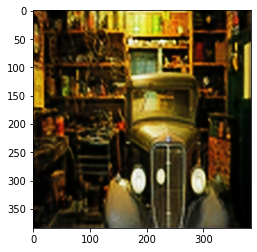

In [20]:
from keras.preprocessing.image import array_to_img

esrgan_pre_gen_pred = generator.predict(np.array([LR_val[0]]))
plt.imshow(array_to_img(esrgan_pre_gen_pred.reshape(high_shape)*255))

In [21]:
class SRGAN_TRAINING(tf.keras.Model):
    def __init__(self, generator, discriminator, vgg, batch_size):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.vgg = vgg
        self.batch_size = batch_size
        
    def compile(self, generator_optimizer, discriminator_optimizer, bce_loss, mse_loss, generator_loss, discriminator_loss, PSNR):
        super().compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.bce_loss = bce_loss
        self.mse_loss = mse_loss
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        self.PSNR = PSNR
        
    def train_step(self, images):
        (lr_images, hr_images) = images
        lr_images = tf.cast(lr_images, tf.float32)
        hr_images = tf.cast(hr_images, tf.float32)

        with tf.GradientTape() as dis_tape:
            generated_images = self.generator(lr_images)
            raw_fake = self.discriminator(generated_images)
            raw_real = self.discriminator(hr_images)

            d_loss = self.discriminator_loss(raw_real, raw_fake)

        grads = dis_tape.gradient(d_loss, self.discriminator.trainable_variables)    
        self.discriminator_optimizer.apply_gradients(zip(grads,self.discriminator.trainable_variables))
        
        miss_leading_labels = np.ones((self.batch_size, 1))
        
        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(lr_images)
            raw_fake = self.discriminator(generated_images)
            raw_real = self.discriminator(hr_images)

            #g_loss = self.generator_loss(raw_fake)
            relativistic_preds = raw_fake - tf.reduce_mean(raw_real)
            predictions = tf.keras.activations.sigmoid(relativistic_preds)
            
            g_loss = self.bce_loss(miss_leading_labels, predictions)
            
            pixel_loss = self.mse_loss(hr_images, generated_images)

            sr_VGG = tf.keras.applications.vgg19.preprocess_input(generated_images)
            sr_VGG = self.vgg(sr_VGG) / 12.75
            hr_VGG = tf.keras.applications.vgg19.preprocess_input(hr_images)
            hr_VGG = self.vgg(hr_VGG) / 12.75

            perc_loss = self.mse_loss(hr_VGG, sr_VGG)
            
            psnr = self.PSNR(hr_images, generated_images)
            
            g_total_loss = 5e-3 * g_loss + perc_loss + 1e-2 * pixel_loss
            
        grads = gen_tape.gradient(g_total_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        
        return {"d_loss": d_loss, "g_total_loss": g_total_loss, "g_loss": g_loss, 
                "perceptual_loss": perc_loss, "pixel_loss": pixel_loss, "PSNR": psnr}

In [22]:
vgg = build_VGG()
csv_logger = tf.keras.callbacks.CSVLogger('GAN_training.log', separator=',', append=False)

discriminator = discriminator(feature_maps=FEATURE_MAPS, 
                                     leaky_alpha=LEAKY_ALPHA,
                                     kernel_size=3,
                                     discriminator_blocks=DISC_BLOCKS)

srgan = SRGAN_TRAINING(generator=generator, discriminator=discriminator, 
                        vgg=vgg, batch_size=TRAIN_BATCH_SIZE)

srgan.compile(discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=FINETUNE_LR),
               generator_optimizer=tf.keras.optimizers.Adam(learning_rate=FINETUNE_LR),
               bce_loss=losses.bce_loss,
               mse_loss=losses.mse_loss,
               generator_loss=losses.generator_loss,
               discriminator_loss=losses.discriminator_loss,
               PSNR=losses.PSNR)

print("[INFO] training ESRGAN...")
srgan.fit(LR_train, HR_train, epochs=FINETUNE_EPOCHS, batch_size=TRAIN_BATCH_SIZE,callbacks=csv_logger )

print("[INFO] saving ESRGAN generator to {}...".format(ESRGAN_model_path))
srgan.generator.save(ESRGAN_model_path)

80150528/80134624 [==============================] - 1s 0us/step
[INFO] training ESRGAN...
Epoch 1/1000


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


9/9 [==============================] - 22s 1s/step - d_loss: 2.7049 - g_total_loss: 3.6619 - g_loss: 0.6969 - perceptual_loss: 0.1464 - pixel_loss: 351.2003 - PSNR: 22.9398
Epoch 2/1000
9/9 [==============================] - 10s 1s/step - d_loss: 1.8601 - g_total_loss: 3.5533 - g_loss: 0.7073 - perceptual_loss: 0.1478 - pixel_loss: 340.2007 - PSNR: 22.8715
Epoch 3/1000
9/9 [==============================] - 11s 1s/step - d_loss: 1.5941 - g_total_loss: 3.5238 - g_loss: 0.7142 - perceptual_loss: 0.1432 - pixel_loss: 337.6999 - PSNR: 21.3866
Epoch 4/1000
9/9 [==============================] - 10s 1s/step - d_loss: 1.3741 - g_total_loss: 3.4830 - g_loss: 0.7246 - perceptual_loss: 0.1446 - pixel_loss: 333.4752 - PSNR: 24.8859
Epoch 5/1000
9/9 [==============================] - 10s 1s/step - d_loss: 1.3280 - g_total_loss: 3.6676 - g_loss: 0.7348 - perceptual_loss: 0.1469 - pixel_loss: 351.7037 - PSNR: 23.2750
Epoch 6/1000
9/9 [==============================] - 10s 1s/step - d_loss: 1.3134 - 

In [23]:
lr_image, hr_image = LR_val, HR_val

print("[INFO] loading the pre-trained and fully trained ESRGAN model...")
esrgan_pre_gen = load_model(gen_model_path, compile=False)
esrgan_gen = load_model(ESRGAN_model_path, compile=False)

#esrgan_pre_gen = load_model("../input/models/generator_model.h5", compile=False)
#esrgan_gen = load_model("../input/trainedmodel/ESRGAN_model.h5", compile=False)

#esrgan_pre_gen = generator
#esrgan_gen = esrgan

print("[INFO] making predictions with pre-trained and fully trained ESRGAN model...")
esrgan_pre_gen_pred = esrgan_pre_gen.predict(lr_image)
esrgan_gen_pred = esrgan_gen.predict(hr_image)

[INFO] loading the pre-trained and fully trained ESRGAN model...
[INFO] making predictions with pre-trained and fully trained ESRGAN model...


In [24]:
from matplotlib.pyplot import subplots, savefig, title, xticks, yticks, show
from keras.preprocessing.image import array_to_img
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import os

def zoom_into_images(image, imageTitle):
    (fig, ax) = subplots()
    im = ax.imshow(array_to_img(image[::-1]), origin="lower")
    title(imageTitle)

    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(array_to_img(image[::-1]), origin="lower")

    (x1, x2, y1, y2) = 20, 40, 20, 40

    axins.set_xlim(x1, x2)

    axins.set_ylim(y1, y2)

    yticks(visible=False)
    xticks(visible=False)

    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")

    imagePath = os.path.join(BASE_IMAGE_PATH, f"{imageTitle}.png")
    savefig(imagePath)

    show()

[INFO] plotting the ESRGAN predictions...
[INFO] saving the ESRGAN predictions to disk...


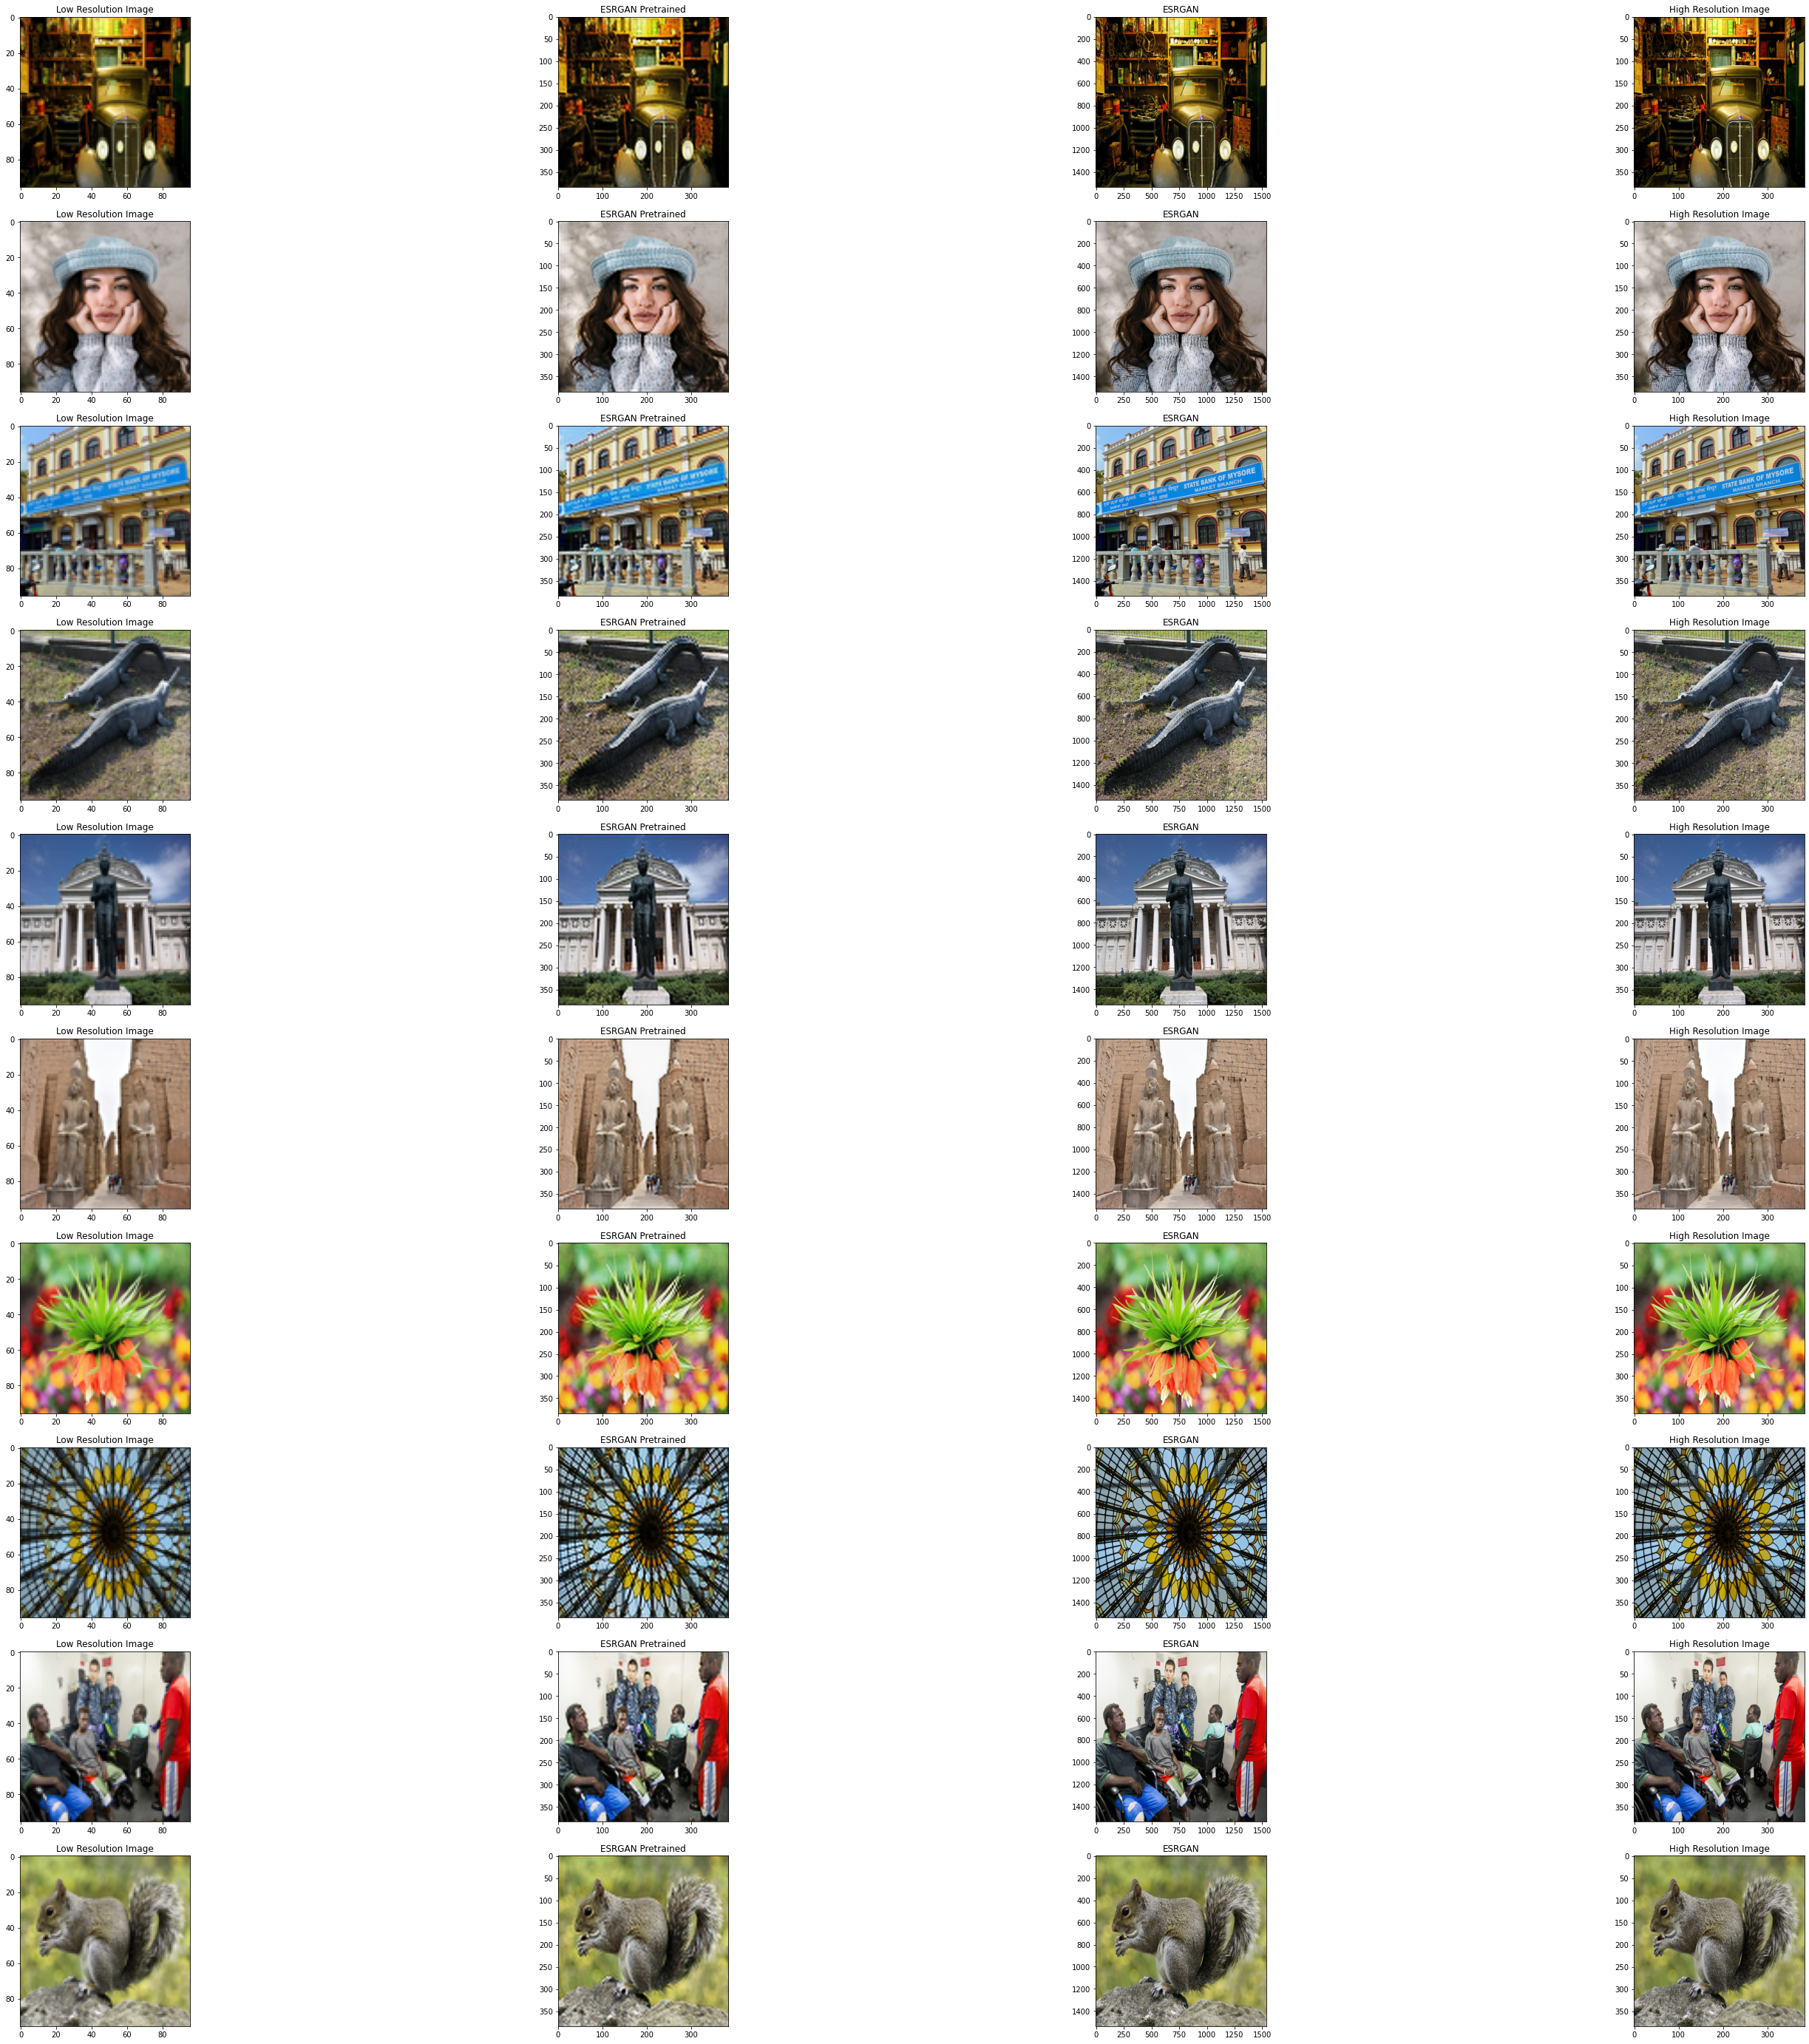

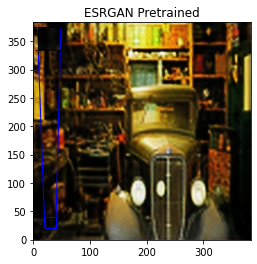

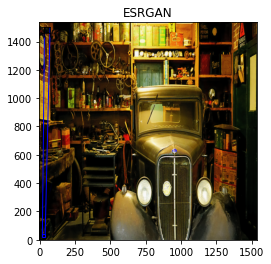

In [25]:
GRID_IMAGE_PATH = os.path.join(BASE_IMAGE_PATH, "grid.png")

print("[INFO] plotting the ESRGAN predictions...")
(fig, axes) = subplots(nrows=INFER_BATCH_SIZE, ncols=4,figsize=(50, 50))

for (ax, lowRes, esrPreIm, esrGanIm, highRes) in zip(axes, 
                                                     lr_image, esrgan_pre_gen_pred, 
                                                     esrgan_gen_pred, hr_image):
    ax[0].imshow(array_to_img(lowRes))
    ax[0].set_title("Low Resolution Image")

    ax[1].imshow(array_to_img(esrPreIm))
    ax[1].set_title("ESRGAN Pretrained")

    ax[2].imshow(array_to_img(esrGanIm))
    ax[2].set_title("ESRGAN")

    ax[3].imshow(array_to_img(highRes))
    ax[3].set_title("High Resolution Image")

if not os.path.exists(BASE_IMAGE_PATH):
    os.makedirs(BASE_IMAGE_PATH)

print("[INFO] saving the ESRGAN predictions to disk...")
fig.savefig(GRID_IMAGE_PATH)

zoom_into_images(esrgan_pre_gen_pred[0], "ESRGAN Pretrained")
zoom_into_images(esrgan_gen_pred[0], "ESRGAN")